# Covid19
These are some visualizations from John Hopkin's repo [COVID-19](https://github.com/CSSEGISandData/COVID-19).

In [27]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import git

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,6)

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [28]:
# git.Repo.clone_from("https://github.com/CSSEGISandData/COVID-19", "COVID-19");
g = git.cmd.Git("COVID-19")
g.pull()

'Updating 1eb3728..0d2b104\nFast-forward\n .../csse_covid_19_daily_reports/03-20-2020.csv     | 300 +++++++\n .../time_series_19-covid-Confirmed.csv             | 961 +++++++++++----------\n .../time_series_19-covid-Deaths.csv                | 961 +++++++++++----------\n .../time_series_19-covid-Recovered.csv             | 961 +++++++++++----------\n 4 files changed, 1776 insertions(+), 1407 deletions(-)\n create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/03-20-2020.csv'

# Deaths

In [29]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
# df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [30]:
def csv_to_timeseries(df,field,value):
    """Convert one row of the raw dataframe to a TimeSeries.
    
    Arguments
    ---------
    field: str, name of the column to filter by (e.g. "Country/Region")
    country: str, value of the column to filter by (eg. "Italy")
    
    Returns
    -------
    Series object, indexed by date with death counts
    """
    
    d = df.groupby(field).get_group(value).agg(sum) # compute total over provinces
    d.drop(labels=["Province/State","Country/Region","Lat","Long"],inplace=True)
    d.index = pd.to_datetime(d.index)
    
    d = d.astype('int32')
    
    return d[d>0]

## Extract timeseries

Which countries have the most deaths until now?

In [31]:
df.groupby('Country/Region').sum().sort_values(by='3/14/20',ascending=False).head(10)

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
China,1083.3367,3684.4197,17,18,26,42,56,82,131,133,...,3161,3172,3180,3193,3203,3217,3230,3241,3249,3253.0
Italy,43.0000,12.0000,0,0,0,0,0,0,0,0,...,827,827,1266,1441,1809,2158,2503,2978,3405,4032.0
Iran,32.0000,53.0000,0,0,0,0,0,0,0,0,...,354,429,514,611,724,853,988,1135,1284,1433.0
Spain,40.0000,-4.0000,0,0,0,0,0,0,0,0,...,54,55,133,195,289,342,533,623,830,1043.0
France,29.8357,177.0593,0,0,0,0,0,0,0,0,...,48,48,79,91,91,148,148,148,243,450.0
"Korea, South",36.0000,128.0000,0,0,0,0,0,0,0,0,...,60,66,66,72,75,75,81,84,91,94.0
US,9586.4294,-23112.4301,0,0,0,0,0,0,0,0,...,36,40,47,54,63,85,108,118,200,244.0
Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,...,15,16,19,22,22,27,29,29,29,33.0
United Kingdom,263.4909,-223.8946,0,0,0,0,0,0,0,0,...,8,8,8,21,21,56,56,72,138,178.0


In [32]:
ita = csv_to_timeseries(df,"Country/Region","Italy")
ira = csv_to_timeseries(df,"Country/Region","Iran")
hub = csv_to_timeseries(df,"Province/State","Hubei")
kor = csv_to_timeseries(df,"Country/Region","Korea, South")
esp = csv_to_timeseries(df,"Country/Region","Spain")
usa = csv_to_timeseries(df,"Country/Region","US")

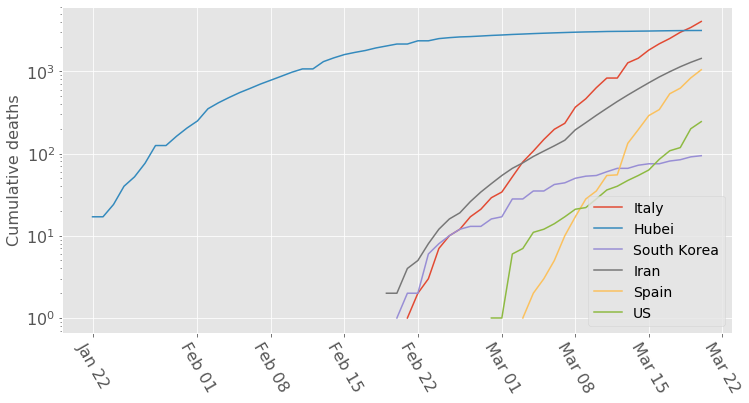

In [33]:
plt.plot(ita,label="Italy")
plt.plot(hub,label="Hubei")
plt.plot(kor,label="South Korea")
plt.plot(ira,label="Iran")
plt.plot(esp,label="Spain")
plt.plot(usa,label="US")

plt.yscale('log')
plt.ylabel('Cumulative deaths')
plt.xticks(rotation=-60)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend();

## Logistic growth model
The number of deaths is well predicted by a simple logistic model.

Let's look at the daily increase factor, defined as the logarithmic derivative:
$$
r = \frac{f'(t)}{f(t)}
$$
which is useful to distinguish between an exponential and a logistic growth: for an exponential it is constant (equal to the typical time), while for a logistic curve it's 
$$
\frac{1}{e^{(t-t_0)/\tau} + 1} \frac{1}{\tau}
$$
and it eventually approaches zero.

Of course, this data is discrete, so we have to use an approximation for the derivative.

In [34]:
def logistica(x,a,b,x0): return a/(1+np.exp(-b*(x-x0)))

def rate_logistica(x,a,b,x0): return b/(1+np.exp(b*(x-x0)))

def gompertz(x,a,b,x0): return a*np.exp(-np.exp(-b*(x-x0)))

def rate_gompertz(x,a,b,x0): return b*np.exp(-b*(x-x0))

def esponenziale(x,b,x0): return np.exp((x-x0)/b)

def rate_esponenziale(x,b,x0): return 1./b
rate_esponenziale = np.vectorize(rate_esponenziale)

In [35]:
def logder(data):
    return (data.shift(-1) - data.shift(1))/(2*data)

def errprop(data):
    return ( np.sqrt(data.shift() + data.shift(-1))/(data.shift(-1)-data.shift(1)) + np.sqrt(data)/data)*logder(data)

# USA

In [36]:
usa = usa[usa>1]
giorni_trascorsi = (usa.index-usa.index[0]).days
err = np.sqrt(usa)

In [37]:
p0 = [1e3,1,2]
# lopt,lcov = curve_fit(logistica,
#                       giorni_trascorsi,
#                       usa,
#                       p0=p0,sigma=err)

In [38]:
p0 = [1,1]
eopt,ecov = curve_fit(esponenziale,
                      giorni_trascorsi,
                      usa,
                      p0=p0,sigma=err)

In [39]:
p0 = [1e5,1,1]
# gopt,gcov = curve_fit(gompertz,
#                       giorni_trascorsi,
#                       usa,
#                       p0=p0,sigma=err)

# print("Modello logistico:")
# print("Numero totale usa stimato: {}".format(int(lopt[0])))
# print("Tempo tipico di crescita: {:.2} giorni".format(1/lopt[1]))
# inflection_date = usa.index[0] + pd.to_timedelta(lopt[2],unit='D')
# print("Data di flessione: "+inflection_date.strftime("%F"))

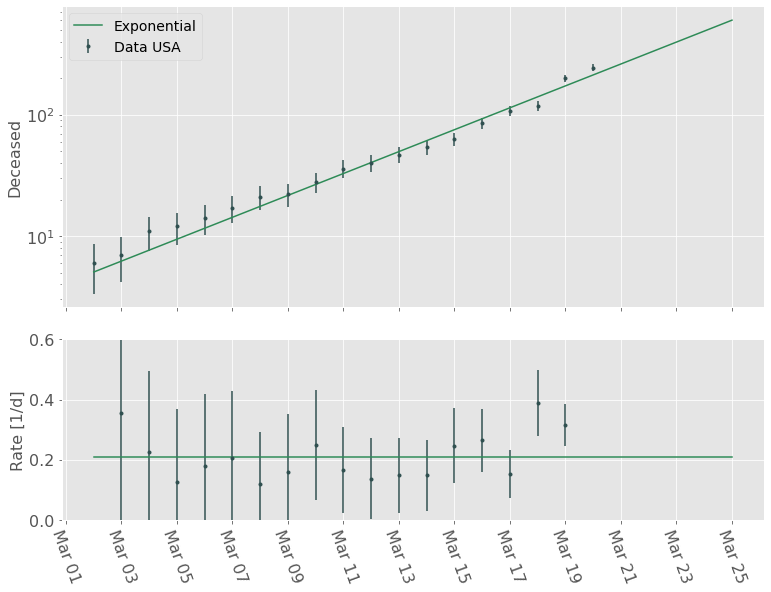

In [40]:
date_proiezione = pd.date_range(usa.index[0],'2020-03-25')

fig,ax = plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [5, 3]},figsize=(11,8))

fig.tight_layout()

ax[0].errorbar(usa.index,usa,
            yerr=np.sqrt(usa+1), 
            fmt=".", 
            color="darkslategray", 
            label="Data USA")


# ax[0].plot(date_proiezione,logistica((date_proiezione-usa.index[0]).days, *lopt),label="Logistica",color='crimson')
# ax[0].plot(date_proiezione,gompertz((date_proiezione-usa.index[0]).days, *gopt),label="Gompertz",color="cornflowerblue")
ax[0].plot(date_proiezione,esponenziale((date_proiezione-usa.index[0]).days, *eopt),label="Exponential",color='seagreen')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Deceased')
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


ax[1].errorbar(x=usa.index,y=logder(usa),yerr=errprop(usa),fmt='.',color='darkslategray')
# ax[1].plot(date_proiezione,rate_gompertz((date_proiezione-usa.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
# ax[1].plot(date_proiezione,rate_logistica((date_proiezione-usa.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[1].plot(date_proiezione,rate_esponenziale((date_proiezione-usa.index[0]).days, *eopt),label="Exponential",color='seagreen')
# ax[1].legend()

ax[1].tick_params(axis='x', rotation=-70)
ax[1].set_xlabel('')
ax[1].set_ylim(bottom=0,top=0.6)
ax[1].set_ylabel('Rate [1/d]')
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## South Korea

In [41]:
kor = kor['2020-02-20':]

In [42]:
# kor = kor[kor>1]
giorni_trascorsi = (kor.index-kor.index[0]).days
err = np.sqrt(kor)

In [43]:
p0 = [1e3,1,2]
lopt,lcov = curve_fit(logistica,
                      giorni_trascorsi,
                      kor,
                      p0=p0,sigma=err)

In [44]:
p0 = [1,1]
eopt,ecov = curve_fit(esponenziale,
                      giorni_trascorsi,
                      kor,
                      p0=p0,sigma=err)

In [45]:
p0 = [1e5,1,1]
gopt,gcov = curve_fit(gompertz,
                      giorni_trascorsi,
                      kor,
                      p0=p0,sigma=err)

print("Modello logistico:")
print("Numero totale stimato: {}".format(int(lopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/lopt[1]))
inflection_date = usa.index[0] + pd.to_timedelta(lopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))

Modello logistico:
Numero totale stimato: 88
Tempo tipico di crescita: 4.4 giorni
Data di flessione: 2020-03-17


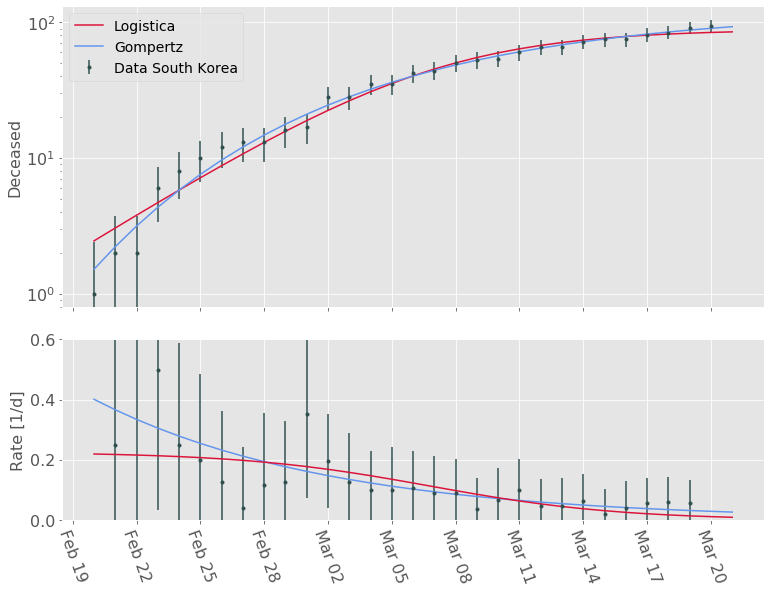

In [46]:
date_proiezione = pd.date_range(kor.index[0],'2020-03-21')

fig,ax = plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [5, 3]},figsize=(11,8))

fig.tight_layout()

ax[0].errorbar(kor.index,kor,
            yerr=np.sqrt(kor+1), 
            fmt=".", 
            color="darkslategray", 
            label="Data South Korea")


ax[0].plot(date_proiezione,logistica((date_proiezione-kor.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[0].plot(date_proiezione,gompertz((date_proiezione-kor.index[0]).days, *gopt),label="Gompertz",color="cornflowerblue")
# # ax[0].plot(date_proiezione,esponenziale((date_proiezione-kor.index[0]).days, *eopt),label="Exponential",color='seagreen')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Deceased')


ax[1].errorbar(x=kor.index,y=logder(kor),yerr=errprop(kor),fmt='.',color='darkslategray')
ax[1].plot(date_proiezione,rate_gompertz((date_proiezione-kor.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
ax[1].plot(date_proiezione,rate_logistica((date_proiezione-kor.index[0]).days, *lopt),label="Logistica",color='crimson')
# ax[1].plot(date_proiezione,rate_esponenziale((date_proiezione-kor.index[0]).days, *eopt),label="Exponential",color='seagreen')
# ax[1].legend()

ax[1].tick_params(axis='x', rotation=-70)
ax[1].set_xlabel('')
ax[1].set_ylim(bottom=0,top=0.6)
ax[1].set_ylabel('Rate [1/d]')
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Spain

In [47]:
# esp = esp[esp>100]
giorni_trascorsi = (esp.index-esp.index[0]).days
err = np.sqrt(esp)

In [48]:
p0 = [1e3,1,2]
lopt,lcov = curve_fit(logistica,
                      giorni_trascorsi,
                      esp,
                      p0=p0,sigma=err)

In [49]:
p0 = [1,1]
eopt,ecov = curve_fit(esponenziale,
                      giorni_trascorsi,
                      esp,
                      p0=p0,sigma=err)

In [50]:
p0 = [1e5,1,1]
# gopt,gcov = curve_fit(gompertz,
#                       giorni_trascorsi,
#                       esp,
#                       p0=p0,sigma=err)

print("Modello logistico:")
print("Numero totale esp stimato: {}".format(int(lopt[0])))
print("Tempo tipico di crescita: {:.2} giorni".format(1/lopt[1]))
inflection_date = esp.index[0] + pd.to_timedelta(lopt[2],unit='D')
print("Data di flessione: "+inflection_date.strftime("%F"))

Modello logistico:
Numero totale esp stimato: 1619
Tempo tipico di crescita: 2.3 giorni
Data di flessione: 2020-03-18


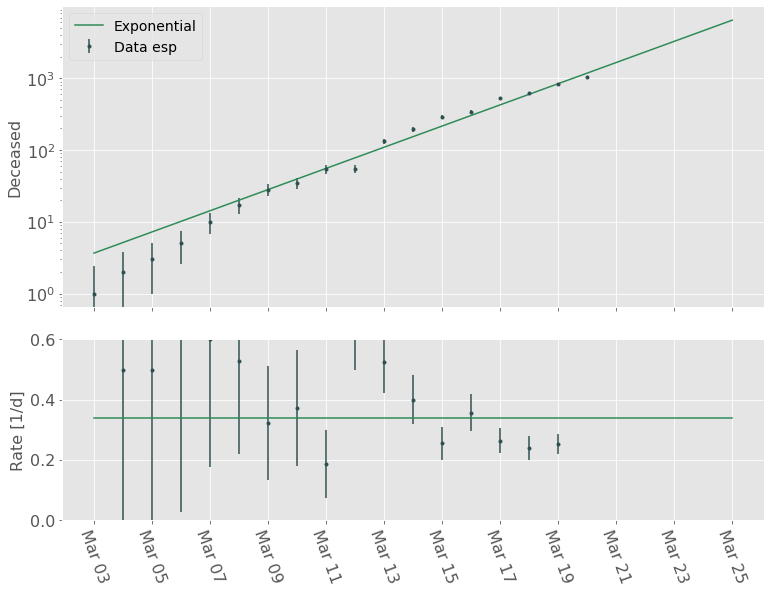

In [51]:
date_proiezione = pd.date_range(esp.index[0],'2020-03-25')

fig,ax = plt.subplots(2,1,sharex=True, gridspec_kw={'height_ratios': [5, 3]},figsize=(11,8))

fig.tight_layout()

ax[0].errorbar(esp.index,esp,
            yerr=np.sqrt(esp+1), 
            fmt=".", 
            color="darkslategray", 
            label="Data esp")


# ax[0].plot(date_proiezione,logistica((date_proiezione-esp.index[0]).days, *lopt),label="Logistica",color='crimson')
# ax[0].plot(date_proiezione,gompertz((date_proiezione-esp.index[0]).days, *gopt),label="Gompertz",color="cornflowerblue")
ax[0].plot(date_proiezione,esponenziale((date_proiezione-esp.index[0]).days, *eopt),label="Exponential",color='seagreen')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Deceased')
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


ax[1].errorbar(x=esp.index,y=logder(esp),yerr=errprop(esp),fmt='.',color='darkslategray')
# ax[1].plot(date_proiezione,rate_gompertz((date_proiezione-esp.index[0]).days, *gopt),label="Gompertz",color='cornflowerblue')
# ax[1].plot(date_proiezione,rate_logistica((date_proiezione-esp.index[0]).days, *lopt),label="Logistica",color='crimson')
ax[1].plot(date_proiezione,rate_esponenziale((date_proiezione-esp.index[0]).days, *eopt),label="Exponential",color='seagreen')
# ax[1].legend()

ax[1].tick_params(axis='x', rotation=-70)
ax[1].set_xlabel('')
ax[1].set_ylim(bottom=0,top=0.6)
ax[1].set_ylabel('Rate [1/d]')
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))